In [21]:
import pandas as pd
import numpy as np
import os, sys
import glob

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
sys.path.append("..")
from utils.smarts_manipulation import get_smi_prod
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor
import multiprocessing
multiprocessing.set_start_method('spawn', force=True)
from concurrent.futures import ThreadPoolExecutor
from functools import partial
from math import sqrt

from dft_res_utils import compute_r1_r2, gen_feature_df_paral, judge_type

In [22]:
# uncomment on following spe_filename specification lines for using recalculated SPE values
spe_filename = "" 

## CKAs dataset
# merged_df = pd.read_csv('wb97_DFT_res/CKAS_cappingC.csv').drop(columns=['No.'])
# exp_worksheet = pd.read_csv('data/CKAs.csv')
# capping_group = "[*]C"
# spe_filename = "wb97_DFT_res/wb97x2d_CKAs_spe.csv"
# spe_filename = "wb97_DFT_res/ccsdt_CKAs_spe.csv"

# Principles of Polymerization textbook dataset
merged_df = pd.read_csv('wb97_DFT_res/textbook_cappingC.csv').drop(columns=['No.'])
exp_worksheet = pd.read_csv('data/textbook_monomer_react_ratio_smarts.csv')
capping_group = "[*]C"
# spe_filename = "wb97_DFT_res/wb97x2d_textbook_spe.csv"

if os.path.exists(spe_filename):
    spe_df = pd.read_csv(spe_filename)
    if 'No.' in spe_df.columns:
        spe_df = spe_df.drop(columns=['No.'])
    # substitute ['SPE[au]'] col in merged_df with spe_df['SPE[au]'] according to the 'Name'
    merged_df.drop(columns=['SPE[au]'], inplace=True, errors='ignore')
    merged_df = merged_df.merge(spe_df[['Name', 'SPE[au]']], on='Name', how='left')


In [23]:
print(f"Before dropping duplicates: {merged_df.shape[0]} rows")

# drop NAN rows, if any NAN in the row, drop the row
merged_df = merged_df.dropna(how='any')

print(f"After dropping NAN rows: {merged_df.shape[0]} rows")

capping_name = capping_group.replace("*", "").replace("[", "").replace("]", "")
r_low, r_high = 0.001, 50.

Before dropping duplicates: 408 rows
After dropping NAN rows: 408 rows


In [24]:
final_df = gen_feature_df_paral(exp_worksheet, merged_df,
                                feature_list=['Hcorr[au]', 'SPE[au]', 'TS[au]', 'ZPE[au]'],
                                capping_group=capping_group,
                                expected_mol_num=12)
final_df.head(3)

100%|██████████| 79/79 [00:00<00:00, 84.90it/s] 

num of success: 79
num of error: 0


,Monomer_1,Monomer_2,r1,r2,T,mol1_Hcorr[au],mol1_SPE[au],mol1_TS[au],mol1_ZPE[au],mol2_Hcorr[au],...,sm12_TS[au],sm12_ZPE[au],sm21_Hcorr[au],sm21_SPE[au],sm21_TS[au],sm21_ZPE[au],sm22_Hcorr[au],sm22_SPE[au],sm22_TS[au],sm22_ZPE[au]
0,Acrylic acid,n-Butyl methacrylate,0.24,3.50,323,0.073856,-267.205984,0.033916,0.067902,0.222796,...,0.070372,0.317013,0.339363,-770.900683,0.070505,0.317452,0.487884,-967.485681,0.084260,0.459122
1,Acrylic acid,Styrene,0.25,0.15,333,0.073856,-267.205984,0.033916,0.067902,0.142028,...,0.058912,0.241945,0.257614,-616.781244,0.059418,0.240912,0.325902,-659.244043,0.062144,0.307733
2,Acrylic acid,Vinyl acetate,8.70,0.21,343,0.073856,-267.205984,0.033916,0.067902,0.102498,...,0.059505,0.201632,0.218486,-613.609376,0.061023,0.201470,0.247358,-652.923225,0.063730,0.228640


In [25]:
filtered_result_df = final_df.groupby(['Monomer_1', 'Monomer_2']).agg({
    feature: 'mean' for feature in final_df.columns if feature not in ['Monomer_1', 'Monomer_2',]
}).reset_index()
filtered_result_df.head(3)

,Monomer_1,Monomer_2,r1,r2,T,mol1_Hcorr[au],mol1_SPE[au],mol1_TS[au],mol1_ZPE[au],mol2_Hcorr[au],...,sm12_TS[au],sm12_ZPE[au],sm21_Hcorr[au],sm21_SPE[au],sm21_TS[au],sm21_ZPE[au],sm22_Hcorr[au],sm22_SPE[au],sm22_TS[au],sm22_ZPE[au]
0,"1,3-Butadiene",Acrylonitrile,0.36,0.046,313.0,0.091212,-156.000959,0.03208,0.085612,0.056336,...,0.052675,0.175980,0.189604,-366.755936,0.052675,0.175980,0.224149,-351.911735,0.054141,0.209907
1,"1,3-Butadiene",Methyl acrylate,1.10,0.070,278.0,0.091212,-156.000959,0.03208,0.085612,0.103502,...,0.058811,0.220322,0.236515,-502.420850,0.058811,0.220322,0.224149,-351.911735,0.054141,0.209907
2,"1,3-Butadiene",Methyl methacrylate,0.75,0.250,363.0,0.091212,-156.000959,0.03208,0.085612,0.133097,...,0.060556,0.248677,0.266925,-541.739591,0.060950,0.249298,0.308812,-731.571144,0.067831,0.287933


In [26]:
ZPE_corr = .9750 # wB97XD, def2-TZVP, Trular
compute_r1_r2_zpe_corr = partial(compute_r1_r2, ZPE_corr=ZPE_corr)

# compute r1 and r2 predicted value for each row
filtered_result_df['r1_pred'], filtered_result_df['r2_pred'] = zip(
    *filtered_result_df.apply(compute_r1_r2_zpe_corr, axis=1))

# squeeze predicted r to r_min and r_max
filtered_result_df['r1_pred'] = filtered_result_df[
    'r1_pred'].clip(lower=r_low, upper=r_high)
filtered_result_df['r2_pred'] = filtered_result_df[
    'r2_pred'].clip(lower=r_low, upper=r_high)
filtered_result_df.dropna(how='any', inplace=True)
filtered_result_df = filtered_result_df.reset_index(drop=True)

filtered_result_df['r1'] = filtered_result_df['r1'].clip(lower=r_low, upper=r_high)
filtered_result_df['r2'] = filtered_result_df['r2'].clip(lower=r_low, upper=r_high)

In [27]:
logr_value_array = np.log(np.maximum(
    r_low, pd.concat([filtered_result_df['r1'], filtered_result_df['r2']])))
pred_logr_value_array = np.log(np.maximum(
    r_low, pd.concat([filtered_result_df['r1_pred'], 
                      filtered_result_df['r2_pred']])))

# Compute RMSE, MAE, and R-squared
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
rmse = sqrt(mean_squared_error(logr_value_array, pred_logr_value_array))
mae = mean_absolute_error(logr_value_array, pred_logr_value_array)
r_squared = r2_score(logr_value_array, pred_logr_value_array)
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R-squared: {r_squared:.3f}")

RMSE: 3.64
MAE: 2.87
R-squared: -0.882


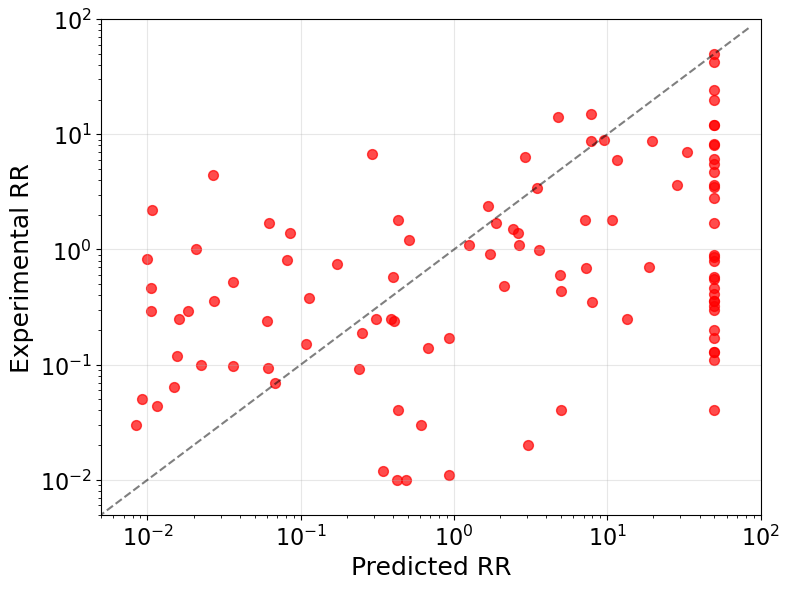

In [28]:
import matplotlib.pyplot as plt

r_value_array = pd.concat([filtered_result_df['r1'], filtered_result_df['r2']])
pred_r_value_array = pd.concat([filtered_result_df['r1_pred'], filtered_result_df['r2_pred']])

# Create scatter plot of experimental vs predicted reactivity ratios
fig, ax = plt.subplots(figsize=(8, 6))

# Plot r1 values
ax.scatter(pred_r_value_array, r_value_array, 
           alpha=0.7, s=50, c='red')


# Set log scale for both axes
ax.set_xscale('log')
ax.set_yscale('log')

# Plot y=x line in dotted style
min_val = min(ax.get_xlim()[0], ax.get_ylim()[0])
max_val = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='y=x')

# Set labels and title
ax.set_xlabel('Predicted RR', fontsize=18)
ax.set_ylabel('Experimental RR', fontsize=18)

ax.set_xlim(0.005, 100)
ax.set_ylim(0.005, 100)

# enlarge the font size of the axis
ax.tick_params(axis='both', which='major', labelsize=16)
# ax.set_title('Experimental vs Predicted RR')

# Add legend
# ax.legend()

# Add grid for better readability
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [29]:
pred_r_value_array = np.exp(pred_logr_value_array.values)
r_value_array = np.exp(logr_value_array.values)

pred_label = np.array(list(map(
    judge_type, np.concatenate(
        [pred_r_value_array[:pred_r_value_array.shape[0]//2][:,None], pred_r_value_array[pred_r_value_array.shape[0]//2:][:,None]],
        axis=1).tolist())))
true_label = np.array(list(map(
    judge_type, np.concatenate(
        [r_value_array[:r_value_array.shape[0]//2][:, None], r_value_array[r_value_array.shape[0]//2:][:, None]],
        axis=1).tolist())))

In [30]:
accuracy = np.sum(pred_label == true_label) / len(true_label)
print(f"Accuracy: {accuracy:.4f}")

from sklearn.metrics import f1_score
f1 = f1_score(pred_label, true_label, average='weighted')
print(f"test F1 score: {f1:.4f}")

Accuracy: 0.4286
test F1 score: 0.3770


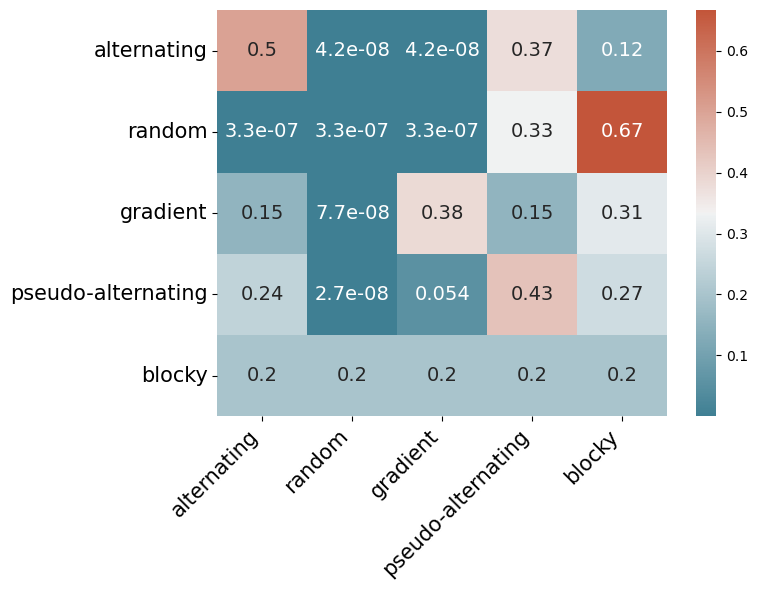

In [31]:
from dft_res_utils import plot_confusion_matrix

type2label = {"alternating":0, "random":1, "gradient":2, "pseudo-alternating":3, "blocky":4 }

plot_confusion_matrix(true_label, pred_label, fig_name="")

In [32]:
true_label_list = true_label.tolist()

label2type = {
    0: "alternating",
    1: "random",
    2: "gradient",
    3: "pseudo-alternating",
    4: "blocky"
}
type_num_list = []
for label in set(true_label_list):
    type_ = label2type[label]
    print(f"label: {type_}")
    print(f"num of {type_}: {true_label_list.count(label)}")
    type_num_list.append(true_label_list.count(label))
    print("=========================================")

label: alternating
num of alternating: 24
label: random
num of random: 3
label: gradient
num of gradient: 13
label: pseudo-alternating
num of pseudo-alternating: 37
